In [502]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from scipy.integrate import solve_ivp
exp=np.exp

def alpha_m (V):
    return  -0.025*(V+40.)/( exp(-(V+40)/10) - 1.0 )

def beta_m(V):
    return exp(-(V+65)/18)

def mNa_inf(V):
    return alpha_m(V) / (alpha_m(V) + beta_m(V))

def tau_mNa(V):
    return 1 / (alpha_m(V) + beta_m(V))/5

def alpha_h(V):
    return 0.0175*exp(-(V+65)/20)

def beta_h(V):
    return 0.25/(1.0 + exp(-(V+35)/10) )

def hNa_inf(V):
    return alpha_h(V) / (alpha_h(V) + beta_h(V))

def tau_hNa (V):
    return 1 / (alpha_h(V) + beta_h(V))/5
Kdshift=10.0

def alpha_mKd(V):
    return 0.0025*(V+55.)/(1. - exp(-(V+55.)/10.))


def beta_mKd(V):
    return 0.03125*exp(-(V+65.)/80.)


def mKd_inf (V):
    return alpha_mKd(V-Kdshift) / (alpha_mKd(V-Kdshift) + beta_mKd(V-Kdshift))

def tau_mKd (V):
    return 1 / (alpha_mKd(V-Kdshift) + beta_mKd(V-Kdshift))/5 


def mA_inf (V):
    return 1/(1+exp(-(V+90)/8.5))

def tau_mA (V):
    return 0.37 + 1/(exp((V+35.82)/19.697)+exp((V+79.69)/-12.7))/5 

def hA_inf (V):
    return 1/(1+exp((V+78)/6))


def tau_hA(V): # Inactivation time-constant
    if (V < -63):
        tau_hA = 1/(exp((V+46.05)/5)+exp((V+238.4)/-37.45))
    else:
        tau_hA = 19
    return tau_hA/5


def mKir_inf (V):
    return 1/(1+exp((V+97.9+10)/9.7))

# T-type Ca-current (mt=activation variable, ht=inactivation variable)

def mt_inf (V):
    return 1/(1+exp(-(V+57)/6.2)) # Activation function

def tau_mt (V):
    return 0.612 + 1/(exp(-(V+131.6)/16.7)+exp((V+16.8)/18.2)) # Activation time-constant

def ht_inf(V):
    return 1/(1+exp((V+81)/4.03)) # Inactivation function

def tau_ht(V): # Inactivation time-constant
    if (V < -80):
        tau_ht = exp((V+467)/66.6)
    else:
        tau_ht = (exp(-(V+21.88)/10.2)+28)
    return tau_ht


# L-type Ca-current (mL=activation variable)

def mL_inf (V):
    return 1/(1+exp(-(V+55.)/3)) # Activation function

def tau_mL(V):
    return (72*exp(-(V+45.)**2/400)+6.) # Activation time-constant

# H-current (mH=activation variable)

def alpha_mH (V):
    return exp(-14.59-(0.086*V))

def beta_mH (V):
    return exp(-1.87+(0.0701*V))
 
def mH_inf (V):
    return  alpha_mH(V) /(alpha_mH(V) + beta_mH(V)) # Activation function
 
def tau_mH (V):
    return 1/(alpha_mH(V) + beta_mH(V)) # Activation time-constant
 
def heaviside (t):
    return (1+np.sign(t))/2 
 
def pulse (t,ti,tf):
    return heaviside(t-ti)-heaviside(t-tf)

sin=np.sin
pi=np.pi


In [503]:
@jit
def HM_ODE(t,u):
    # Parameters
    Iapp=p[0] # Amplitude of constant applied current
    I1=p[1] # Amplitude of first step input
    I2=p[2] # Amplitude of second step input
    ti1=p[3] # Starting time of first step input
    tf1=p[4] # Ending time of first step input
    ti2=p[5] # Starting time of second step input
    tf2=p[6] # Ending time of second step input
    gT=p[7] # T-type calcium current maximal conductance
    gKd=p[8]  # Delayed-rectifier potassium current maximal conductance
    gH=p[9] # H-current maximal conductance
    gNa=p[10] # Sodium current maximal conductance
    gA=p[11] # A-type potassium current maximal conductance
    gKir=p[12]  # Inward-rectifier potassium current maximal conductance
    gLeak=p[13] # Leak current maximal conductance
    gL=p[14] # L-type calcium current maximal conductance
    gKCa=p[15] # Calcium-activated potassium current maximal conductance
    C=p[16] # Membrane capacitance
    taunoise=p[18] # Cutoff frequency for low-pass filtered Gaussian noise
    Ain=p[19] # Amplitude of sinusoïdal inut
    Win=p[20] # Frequency of  sinusoïdal inut

    # Variables
    V=u[0] # Membrane potential
    mNa=u[1] # Sodium current activation
    hNa=u[2] # Sodium current inactivation
    mH=u[3] # H current activation
    mt=u[4] # T-type calcium current activation
    ht=u[5] # T-type calcium current inactivation
    mA=u[6] # A-type potassium current activation
    hA=u[7] # A-type potassium current inactivation
    mKd=u[8] # Delayed-rectifier potassium current activation
    mL=u[9] # L-type calcium current activation
    Ca=u[10] # Intracellular calcium concentration
    noise=u[11] # Input noise

    # ODEs
    du1=1/C*(- gNa*mNa**3*hNa*(V-VNa) - gH*mH*(V-VH) - gT*mt**2*ht*(V-VCa) - gA*mA**4*hA*(V-VK) - gKd*mKd**4*(V-VK) -
                gKir*mKir_inf(V)*(V-VK) - gLeak*(V-Vleak)- gL*mL*(V-VCa) - gKCa*(Ca/(15.0+Ca))**4*(V-VK) +
                Iapp + I1*pulse(t,ti1,tf1) + I2*pulse(t,ti2,tf2) + noise + Ain*sin(2*pi*Win*t)) # Voltage equation
    du2=1/tau_mNa(V)*(-mNa+mNa_inf(V)) # gating equation
    du3=1/tau_hNa(V)*(-hNa+hNa_inf(V))
    du4=1/tau_mH(V)*(-mH+mH_inf(V))
    du5=1/tau_mt(V)*(-mt+mt_inf(V))
    du6=1/tau_ht(V)*(-ht+ht_inf(V))
    du7=1/tau_mA(V)*(-mA+mA_inf(V))
    du8=1/tau_hA(V)*(-hA+hA_inf(V))
    du9=1/tau_mKd(V)*(-mKd+mKd_inf(V))
    du10=1/tau_mL(V)*(-mL+mL_inf(V))
    du11=(-0.1*(gL*mL*(V-VCa))-0.01*Ca)/4 # Variation of intracellular calcium concentration
    du12=-noise/taunoise # Noise equation
    
    return [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12]

In [530]:

def  OB_ODE(t,u):
    
    it=iter(u)
    dinamics,Theta,phi,P,u_sys=[[next(it) for _ in range(size)] for size in variable_size]
    
    V,mNa,hNa,mH,mt,ht,mA,hA,mKd,mL,Ca,noise=dinamics
    
    P=np.array(P).reshape([num_phi,num_phi])
    Theta=np.array(Theta)
    phi=np.array(phi)
    
    obesV=u_sys[0]
    
    
    Iapp=p[0] # Amplitude of constant applied current
    I1=p[1] # Amplitude of first step input
    I2=p[2] # Amplitude of second step input
    ti1=p[3] # Starting time of first step input
    tf1=p[4] # Ending time of first step input
    ti2=p[5] # Starting time of second step input
    tf2=p[6] # Ending time of second step input
    gT=p[7] # T-type calcium current maximal conductance
    gKd=p[8]  # Delayed-rectifier potassium current maximal conductance
    gH=p[9] # H-current maximal conductance
    gNa=p[10] # Sodium current maximal conductance
    gA=p[11] # A-type potassium current maximal conductance
    gKir=p[12]  # Inward-rectifier potassium current maximal conductance
    gLeak=p[13] # Leak current maximal conductance
    gL=p[14] # L-type calcium current maximal conductance
    gKCa=p[15] # Calcium-activated potassium current maximal conductance
    C=p[16] # Membrane capacitance
    taunoise=p[18] # Cutoff frequency for low-pass filtered Gaussian noise
    Ain=p[19] # Amplitude of sinusoïdal inut
    Win=p[20] # Frequency of  sinusoïdal inut
    
    
    PHI0= -mNa**3*hNa*(obesV-VNa) 
    PHI1= -mH*(obesV-VH)
    PHI2= -mt**2*ht*(obesV-VCa)
    PHI3= -mA**4*hA*(obesV-VK)
    PHI4= - mKd**4*(obesV-VK)
    PHI5= -mKir_inf(obesV)*(obesV-VK)
    PHI6= -(obesV-Vleak)
    PHI7= -mL*(obesV-VCa)
    PHI8= -(Ca/(15.0+Ca))**4*(obesV-VK) #-gKCa*(Ca/(15.0+Ca))**4*(obesV-VK)
    Current_in= Iapp + I1*pulse(t,ti1,tf1) + I2*pulse(t,ti2,tf2)+ Ain*sin(2*pi*Win*t)
    
    
    PHI= np.array([PHI0,PHI1,PHI2,PHI3,PHI4,PHI5,PHI6,PHI7,PHI8])
    
    #ODEs
    
    du1=1/C*(np.dot(PHI,Theta) + Current_in)+ gamma*(obesV-V)+gamma*np.dot(np.dot(phi,P),phi)*(obesV-V)# Voltage equation
    
    du2=1/tau_mNa(obesV)*(-mNa+mNa_inf(obesV)) # gating equation
    du3=1/tau_hNa(obesV)*(-hNa+hNa_inf(obesV))
    du4=1/tau_mH(obesV)*(-mH+mH_inf(obesV))
    du5=1/tau_mt(obesV)*(-mt+mt_inf(obesV))
    du6=1/tau_ht(obesV)*(-ht+ht_inf(obesV))
    du7=1/tau_mA(obesV)*(-mA+mA_inf(obesV))
    du8=1/tau_hA(obesV)*(-hA+hA_inf(obesV))
    du9=1/tau_mKd(obesV)*(-mKd+mKd_inf(obesV))
    du10=1/tau_mL(obesV)*(-mL+mL_inf(obesV))
    du11=(-0.1*(Theta[7]*mL*(obesV-VCa))-0.01*Ca)/4 # Variation of intracellular calcium concentration
    du12=-noise/taunoise # Noise equation
    
    du13=gamma_mask*np.dot(P,phi)*(obesV-V)#+gamma*np.dot(P,beta*np.absolute(Theta)*(Theta < 0))
    
    du14=mask*(-gamma*phi+PHI) #+np.array([0,0,0,0,0,0,0,(-0.1*(mL*(obesV-VCa))/4)*(-4*Theta[8]*(Ca/(15.0+Ca))**3*(obesV-VK)*15/((15+Ca)),0])
    #du14=(np.absolute(du14)>min_num)*du14
    
    du15=alpha*P-np.dot(np.dot(P,np.outer(phi,phi)),P)
    
    du16=HM_ODE(t,u_sys)
    
    
    return ([[du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12],du13.tolist(),du14.tolist(),du15.flatten().tolist(),du16])

def  OB_ODE2(t,u):
    a,b,c,d,e= OB_ODE(t,u)
    out=[*a,*b,*c,*d,*e]
        
    out=np.nan_to_num(out)
        
    return (out)

In [508]:
#Test real model
## Simulation of the model in current-clamp mode

## Definition of reversal potential values. 
VNa = 45; # Sodium reversal potential 45
VCa = 120.; # Calcium reversal potential
VK = -90.; # Potassium reversal potential -90
VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
Vleak = -55.; # Reversal potential of leak channels

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance

gNa=120.; # Sodium current maximal conductance 120
gKd=80; # Delayed-rectifier potassium current maximal conductance 80
gT=0; # T-type calcium current maximal conductance 2.
gH=0; # H-current maximal conductance 0.1
gL=0.4; # L-type calcium current maximal conductance 0.4
gKCa=2.; # Calcium-activated potassium current maximal conductance 2.
gA=0.; # A-type potassium current maximal conductance
gKir=0.; # Inward-rectifier potassium current maximal conductance

## Definition of simulation time.
Tfinal=2500.0
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=-1

# Current pulses
I1=0. # Amplitude of first pulse
ti1=100 # Starting time of first pulse
tf1=103 # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=200 # Starting time of second pulse
tf2=203 # Ending time of first pulse

# Sinusoidal input
Ain=0.0 # Amplitude
Win=0.0 # Frequency

# Input noise
NoiseIN=0. # Amplitude
TauNoise=2.0 # Cut-off frequency

## Current-clamp experiment
# Parameter vector for simulations
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,C,NoiseIN,TauNoise,Ain,Win]

# Initial conditions
V0= -60.
x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), 0.0]

In [509]:
sol=solve_ivp(HM_ODE ,tspan , x0)

C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\scipy\integrate\_ivp\base.py:21: RuntimeWarning: overflow encountered in double_scalars
  return np.asarray(fun(t, y), dtype=dtype)
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\scipy\integrate\_ivp\base.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return np.asarray(fun(t, y), dtype=dtype)
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:77: R

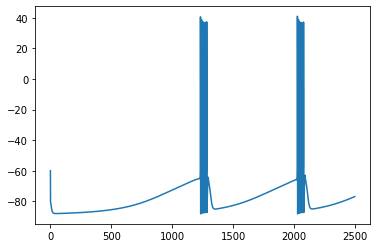

In [510]:
plt.plot(sol.t, sol.y[0])

In [511]:
num_dinamics=12
num_Theta=9
num_phi_=num_Theta
num_phi=num_Theta
num_p=num_Theta**2
num_u_sys=12
variable_size=[num_dinamics,num_Theta,num_phi,num_p,num_u_sys]
beta=100

In [527]:
#Test observer
## Simulation of the model in current-clamp mode

## Definition of reversal potential values. 
VNa = 45.; # Sodium reversal potential
VCa = 120.; # Calcium reversal potential
VK = -90.; # Potassium reversal potential
VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions)
Vleak = -55.; # Reversal potential of leak channels

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance

gNa=120.; # Sodium current maximal conductance 120
gKd=80; # Delayed-rectifier potassium current maximal conductance 80
gT=0; # T-type calcium current maximal conductance 2.
gH=0; # H-current maximal conductance 0.1
gL=0.4; # L-type calcium current maximal conductance 0.4
gKCa=2.; # Calcium-activated potassium current maximal conductance 2.
gA=0.; # A-type potassium current maximal conductance
gKir=0.; # Inward-rectifier potassium current maximal conductance

## Definition of simulation time.
Tfinal=6000.0
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=-1

# Current pulses
I1=0. # Amplitude of first pulse
ti1=100 # Starting time of first pulse
tf1=103 # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=200 # Starting time of second pulse
tf2=203 # Ending time of first pulse

# Sinusoidal input
Ain=0# Amplitude 5
Win=0.5 # Frequency

#Hyperparameters
gamma=10
mask=np.array([1,1,1,1,1,1,1,0,1]) #freeze variable by setting 0 in the mask
gamma_mask=mask*gamma
alpha=0.01

# Input noise
NoiseIN=0. # Amplitude
TauNoise=2.0 # Cut-off frequency

## Current-clamp experiment
# Parameter vector for simulations
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,C,NoiseIN,TauNoise,Ain,Win]

# Initial conditions
V0= -70.
x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), 0.0]
V0_ = -20
x0_= [V0,mNa_inf(V0_),hNa_inf(V0_),mH_inf(V0_),mt_inf(V0_),ht_inf(V0_) ,mA_inf(V0_), hA_inf(V0_), mKd_inf(V0_), mL_inf(V0_), -10*gL*mL_inf(V0_)*(V0_-VCa), 0.0]
"""
du2=1/tau_mNa(V)*(-mNa+mNa_inf(V)) 
    du3=1/tau_hNa(V)*(-hNa+hNa_inf(V))
    du4=1/tau_mH(V)*(-mH+mH_inf(V))
    du5=1/tau_mt(V)*(-mt+mt_inf(V))
    du6=1/tau_ht(V)*(-ht+ht_inf(V))
    du7=1/tau_mA(V)*(-mA+mA_inf(V))
    du8=1/tau_hA(V)*(-hA+hA_inf(V))
    du9=1/tau_mKd(V)*(-mKd+mKd_inf(V))
    du10=1/tau_mL(V)*(-mL+mL_inf(V))
    du11=(-0.1*(gL*mL*(V-VCa))-0.01*Ca)/4 
"""
'''[ 'Na','H','t','A','K','Kir','leak','L','KCa']
    120,0.1,2,0,80,0,0.1,0.4,2
[1.20078309e+02 9.99935030e-02 2.00543802e+00 3.67723634e-06
 8.01004533e+01 0.00000000e+00 1.00000000e-01 3.99355255e-01
 2.00000000e+00]
 [1.19244440e+02 1.07155203e-01 1.97335159e+00 9.41065469e-04
 7.94144652e+01 0.00000000e+00 9.92878415e-02 4.02652110e-01
 2.00000000e+00]
 [ 1.19013827e+02  1.08252336e-01  1.97016712e+00 -1.99602367e-03
  7.92679611e+01  6.14319636e-03  9.91735126e-02  4.02071713e-01
  2.00000000e+00]
  random result:without kca
  [ 1.17175982e+02  1.04500391e-01  1.92046277e+00 -5.58087699e-03
  7.79309064e+01  1.20699524e-02  9.95532125e-02  4.04948400e-01
  2.00000000e+00]
  random result:
  [ 1.19999126e+02  1.00004794e-01  1.99996145e+00 -2.65651809e-07
  7.99992936e+01 -3.46322090e-07  9.99991554e-02  4.00004375e-01
  2.00000076e+00]
  [ 1.19999422e+02  1.00005059e-01  1.99997393e+00 -2.91592737e-07
  7.99995340e+01 -5.14970360e-07  9.99991061e-02  4.00003699e-01
  2.00000085e+00]
  freeze gL:
  [ 1.19972581e+02  9.96883789e-02  1.99934515e+00  1.33240840e-04
  7.99806011e+01 -7.80069862e-03  9.99697610e-02  4.00000000e-01
  2.00023076e+00]
  [42.01092712  1.5494339  -1.31669172 -0.37909282 23.67410391 38.68581827
  0.51652754  0.4         1.26532886]
  Belows are wrong things 
  random result without exteral activation:
  [ 1.31167439e+02  1.38282134e-01  2.16870887e+00 -4.55129802e-02
  8.74956441e+01  1.05995816e+00  1.15554355e-01  4.50523227e-01
  2.21237605e+00]
  (initial parameters:)
  [66.39020777 80.03244816 82.09159447 55.98833481 35.95792441 42.20821261
 35.03867713 35.81015131 68.6287446 ]
  random result without exteral activation:
  [ 1.15774320e+02  1.84234807e-01  1.93446323e+00 -6.25345111e-02
  7.73094729e+01  2.36863544e+00  1.07893157e-01  3.86664383e-01
  1.85472455e+00]
  (initial parameters:)
  [84.91660481  1.74996184 89.22391505 72.74335702 36.56523392  3.79619365
 64.22460498  2.06117465 64.3149428 ]
'''
#Theta0=(np.array([50,1,1,0,70,0,0.1,0.1,2])).tolist()
Theta0= np.random.rand(9)*100
#Theta0[8]=2
Theta0[7]=gL
print(Theta0)
A0=(np.ones(num_Theta)*0.1).tolist()*mask
P0=np.diag(np.diag(np.outer(A0,A0))).flatten().tolist()
#P0[-1]=0
X0_=[*x0_,*Theta0,*A0,*P0,*x0]
print(len(X0_))
print(len(Theta0))

[62.69100964 84.68352714 20.16844765 72.23615192 68.9534577  67.90565095
 32.92393714  0.4        86.74377952]
123
9


In [528]:
print(variable_size)

[12, 9, 9, 81, 12]


In [529]:
sol=solve_ivp(OB_ODE2,tspan , X0_)

C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykerne

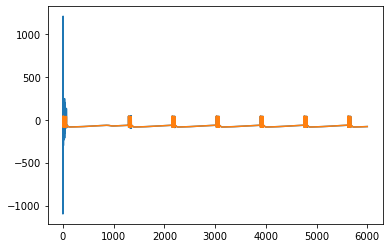

In [531]:
#plot result
plt.plot(sol.t,sol.y[0])
plt.plot(sol.t,sol.y[111])

C:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


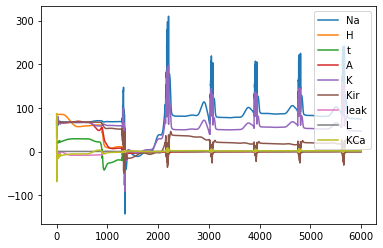

[73.90483573  0.88780774 -0.80674513 -0.23626591 46.5748966  22.50291961
  0.34549259  0.4         1.66570093]


In [532]:
#plot parameters
labels=[ 'Na','H','t','A','K','Kir','leak','L','KCa']
plt.figure()
for i in range(num_Theta):
    plt.plot(sol.t,sol.y[12+i],label=labels[i])
plt.legend()
plt.show()
print(sol.y[12:12+num_Theta,-1])

In [ ]:
[ 1.19999432e+02  1.00346287e-03  5.39420537e-06 -2.85540334e-05
  2.99998680e+01  8.69186195e-04  1.00005380e-01  0.00000000e+00
  3.15466372e+01]
[ 1.19999432e+02  1.00346287e-03  5.39420537e-06 -2.85540334e-05
  2.99998680e+01  8.69186195e-04  1.00005380e-01  0.00000000e+00
  3.15466372e+01]
[1.20000036e+02 3.19298405e-05 6.91271073e-07 8.01713861e-07
 3.00000093e+01 2.98691917e-06 9.99997304e-02 0.00000000e+00
 4.02796069e+01]
[1.20000021e+02 1.92241581e-05 4.83944351e-07 6.17609122e-07
 3.00000055e+01 1.60788221e-06 9.99997988e-02 0.00000000e+00
 8.60830453e+01]
[33.36071185 44.62563514 -2.13997943 -4.24395802  8.53803067 50.74059152
  1.08908056  0.          8.50796964]

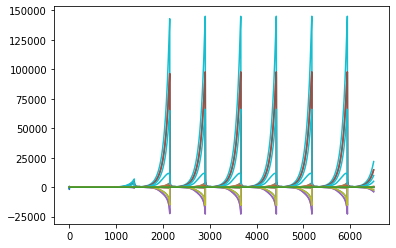

In [464]:
plt.figure()
for i in range(123):
    plt.plot(sol.t,sol.y[0+i])
plt.show()

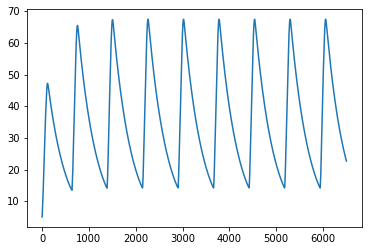

In [419]:
plt.plot(sol.t,sol.y[121])